In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from time import time
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.structure import StructureModel
from typing import List, Tuple
from causalnex.plots import plot_structure
from IPython.display import Image
import dataframe_image
import networkx as nx
import os


In [52]:
def adjacency_correlations(
    data: pd.DataFrame,
    bn: BayesianNetwork,
    method: str,
) -> pd.DataFrame:
    """
    Utility function to compute pairwise correlation of connected nodes in a graph
    Args:
        data: Input dataframe
        bn: Bayesian network
        method: Correlation scoring method - {‘pearson’, ‘kendall’, ‘spearman’} or callable
    Returns:
        Correlation dataframe
    """
    correl_df = data[bn.nodes].corr(method=method)
    edge_set = set(bn.structure.edges())

    for row in correl_df.index:
        for col in correl_df.columns:
            if (row, col) not in edge_set:
                correl_df.loc[row, col] = np.nan

    return correl_df

In [56]:
def display_colored_df(df: pd.DataFrame):
    """
    Utility function to display dataframe as a heatmap
    Args:
        df: Input dataframe
    """

    def display_df_as_img(df):
        temp_file_name = "./temp.png"
        dataframe_image.export(df, temp_file_name)

        with open(temp_file_name, "rb") as file:
            display(Image(file.read()))

        os.remove(temp_file_name)

    if not isinstance(df.columns, pd.MultiIndex) or len(df.columns.names) != 1:
        display_df_as_img(df.style.background_gradient(axis=None))
    else:
        df = df.copy()
        df.columns = df.columns.levels[0]
        display_df_as_img(df.style.background_gradient(axis=None))


In [4]:
pd.set_option('display.max_columns', None)
from datetime import datetime
from dateutil.parser import parse

In [5]:
def read_prep_data(file):
    df = pd.read_csv(r"%s" % file, sep=';')
    # missining selected
    df = df[df['Selected'] != 'missing']  # make sure that we have data for selected attribute

    # CreditScore handeling
    df.CreditScore.replace(0.0, np.nan, inplace=True)
    df['CreditScore'].fillna((df['CreditScore'].median()), inplace=True)

    # MonthlyCost handeling
    df.MonthlyCost.replace(0.0, np.nan, inplace=True)
    df['MonthlyCost'].fillna((df['MonthlyCost'].median()), inplace=True)

    # NumberOfTerms handeling
    df.NumberOfTerms.replace(0.0, np.nan, inplace=True)
    df['NumberOfTerms'].fillna((df['NumberOfTerms'].median()), inplace=True)

    # FirstWithdrawalAmount handeling
    df.FirstWithdrawalAmount.replace(0.0, np.nan, inplace=True)
    df['FirstWithdrawalAmount'].fillna((df['FirstWithdrawalAmount'].median()), inplace=True)

    # map Selected to 1(signed), and 0(not signed)
    df['Selected'] = df['Selected'].map({'True': 1, 'False': 0})

    # for FrequencyOfIncompleteness
    #     df2 = df[df['Activity']=='A_Incomplete']
    #     df_new = pd.DataFrame(df2.groupby(['Case ID'])['Activity'].count()).reset_index()
    #     df_new.columns = ['Case ID', 'FrequencyOfIncompleteness']
    #     df_new = pd.DataFrame(df_new.groupby('Case ID')['FrequencyOfIncompleteness'].sum()).reset_index()
    #     df = pd.merge(df_new, df, on='Case ID')

    # For NumberOfOffers
    df2 = df[df['Activity'] == "O_Created"]  # to count offers
    df_new = pd.DataFrame(df2.groupby(['Case ID'])['Activity'].count()).reset_index()
    df_new.columns = ['Case ID', 'NumberOfOffers']
    df = pd.merge(df_new, df, on='Case ID')

    # For matchRequested
    df['MatchedRequest'] = np.where((df.RequestedAmount <= df.OfferedAmount), 'True', 'False')

    df = df.groupby('Case ID').apply(get_duration)
    df = df.reset_index(drop=True)

    # O_Sent (mail and online)
    #     df2 = df[df['Activity'] == 'O_Sent (mail and online)'] # to count offers
    #     df_new = pd.DataFrame(df2.groupby(['Case ID'])['Activity'].count()).reset_index()
    #     df_new.columns = ['Case ID', 'O_sent_mail_online_frequency']
    #     df = pd.merge(df_new, df, on='Case ID')

    # O_Sent (online only)
    #     df2 = df[df['Activity'] == 'O_Sent (online only)'] # to count offers
    #     df_new = pd.DataFrame(df2.groupby(['Case ID'])['Activity'].count()).reset_index()
    #     df_new.columns = ['Case ID', 'O_sent_online_only_frequency']
    #     df = pd.merge(df_new, df, on='Case ID')

    # binning columns
    #    df['new_duration'] = pd.cut(df['durationDays'], [0,8,15,30,31,168],
    #                                include_lowest=True, right=False, labels=['0-7','8-14','15-29','30','31+'])
    #    df['new_duration'] = df['new_duration'].astype(str)
    #    df['new_FrequencyOfIncompleteness'] = pd.cut(df['FrequencyOfIncompleteness'], 15)
    #    df['new_FrequencyOfIncompleteness'] = df['new_FrequencyOfIncompleteness'].astype(str)xs

    df['binned_RequestedAmount'] = pd.qcut(df['RequestedAmount'], 5, labels=['0-5000', '5001-10000',
                                                                             '10001-15000', '15001-25000', '25000+'])
    df['binned_RequestedAmount'] = df['binned_RequestedAmount'].astype(str)

    df['binned_duration'] = pd.qcut(df['durationDays'], 5, labels=['0-8', '9-13', '14-22', '23-30', '30+'])
    df['binned_duration'] = df['binned_duration'].astype(str)

    df['binned_NoOfTerms'] = pd.qcut(df['NumberOfTerms'], 5, labels=['6-48', '49-60', '61-96', '97-120', '120+'])
    df['binned_NoOfTerms'] = df['binned_NoOfTerms'].astype(str)

    df['binned_CreditScore'] = pd.qcut(df['CreditScore'], 2, labels=['low', 'high'])
    df['binned_CreditScore'] = df['binned_CreditScore'].astype(str)

    df['binned_MonthlyCost'] = pd.qcut(df['MonthlyCost'], 5, labels=['40-148', '149-200', '201-270',
                                                                     '271-388', '388+'])
    df['binned_MonthlyCost'] = df['binned_MonthlyCost'].astype(str)

    df['binned_FirstWithdrawalAmount'] = pd.qcut(df['FirstWithdrawalAmount'], 3,
                                                 labels=['0-7499', '7500-9895', '9896-75000'])
    df['binned_FirstWithdrawalAmount'] = df['binned_FirstWithdrawalAmount'].astype(str)

    df['binned_NumberOfOffers'] = pd.cut(df['NumberOfOffers'], [1, 2, 3, 11],
                                         include_lowest=True, right=False, labels=['1', '2', '3+'])
    df['binned_NumberOfOffers'] = df['binned_NumberOfOffers'].astype(str)

    df = df.groupby('Case ID').apply(keep_last)
    df = df.reset_index(drop=True)

    # lower case
    column = ['ApplicationType', 'LoanGoal', 'MatchedRequest']
    for col in column:
        df[col] = df[col].str.lower()

    return df

def keep_last(group):
    return group.tail(1)


def get_duration(gr):
    df = pd.DataFrame(gr)
    if len(df[(df["Activity"] == "A_Denied") | (df["Activity"] == "A_Cancelled") | (
            df["Activity"] == "A_Pending")]) > 0:
        df['new_date'] = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in df['time:timestamp']]

        first_dt = df[df['Activity'] == 'O_Create Offer']['new_date']
        last_dt = \
            df[(df["Activity"] == "A_Denied") | (df["Activity"] == "A_Cancelled") | (df["Activity"] == "A_Pending")][
                'new_date']

        first_dt = first_dt[first_dt.index.values[0]]
        # print(last_dt)
        last_dt = last_dt[last_dt.index.values[0]]

        d1 = parse(str(first_dt))
        d2 = parse(str(last_dt))

        delta_days = (d2 - d1).days
        # print(delta_days,'\n')
        df['durationDays'] = delta_days
        return df


In [6]:
data = 'BPIC17_O_Accepted.csv'
feat_eng_data = read_prep_data(data)

In [7]:
le = preprocessing.LabelEncoder()

In [8]:
loan_df = pd.read_csv('BPIC17_O_Accepted.csv',sep=";")

In [11]:
loan_df.columns

Index(['ApplicationType', 'LoanGoal', 'RequestedAmount', 'Case ID', 'label',
       'Activity', 'org:resource', 'Action', 'EventOrigin',
       'lifecycle:transition', 'Accepted', 'Selected', 'FirstWithdrawalAmount',
       'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'CreditScore',
       'timesincelastevent', 'timesincecasestart', 'timesincemidnight',
       'event_nr', 'month', 'weekday', 'hour', 'open_cases', 'time:timestamp'],
      dtype='object')

In [12]:
object_cols = ['ApplicationType','RequestedAmount','label','LoanGoal','Activity']
for col in object_cols:
    loan_df[col] = le.fit_transform(loan_df[col])

In [13]:
loan_df_grouped = loan_df.groupby(['Case ID'])

In [67]:
loan_df_grouped.head(10)

,ApplicationType,LoanGoal,RequestedAmount,Case ID,label,Activity,org:resource,Action,EventOrigin,lifecycle:transition,Accepted,Selected,FirstWithdrawalAmount,MonthlyCost,NumberOfTerms,OfferedAmount,CreditScore,timesincelastevent,timesincecasestart,timesincemidnight,event_nr,month,weekday,hour,open_cases,time:timestamp
0,1,2,300,Application_652823628,0,4,User_1,Created,Application,complete,missing,missing,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,591,1,1,4,9,0,2016-01-01 09:51:15.304
1,1,2,300,Application_652823628,0,8,User_1,statechange,Application,complete,missing,missing,0.0,0.00,0.0,0.0,0.0,0.000800,0.000800,591,2,1,4,9,1,2016-01-01 09:51:15.352
2,1,2,300,Application_652823628,0,22,User_1,Created,Workflow,schedule,missing,missing,0.0,0.00,0.0,0.0,0.0,0.007033,0.007833,591,3,1,4,9,1,2016-01-01 09:51:15.774
3,1,2,300,Application_652823628,0,22,User_1,Deleted,Workflow,withdraw,missing,missing,0.0,0.00,0.0,0.0,0.0,1.343633,1.351467,592,4,1,4,9,1,2016-01-01 09:52:36.392
4,1,2,300,Application_652823628,0,21,User_1,Created,Workflow,schedule,missing,missing,0.0,0.00,0.0,0.0,0.0,0.000183,1.351650,592,5,1,4,9,1,2016-01-01 09:52:36.403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198350,1,4,300,Application_1350494635,1,3,User_1,statechange,Application,complete,missing,missing,0.0,0.00,0.0,0.0,0.0,0.000067,0.567267,1298,6,12,5,21,1528,2016-12-31 21:38:27.252
1198351,1,4,300,Application_1350494635,1,21,User_96,Obtained,Workflow,start,missing,missing,0.0,0.00,0.0,0.0,0.0,2736.799367,2737.366633,1155,7,1,0,19,1419,2017-01-02 19:15:15.214
1198352,1,4,300,Application_1350494635,1,0,User_96,statechange,Application,complete,missing,missing,0.0,0.00,0.0,0.0,0.0,6.012517,2743.379150,1161,8,1,0,19,1419,2017-01-02 19:21:15.965
1198353,1,4,300,Application_1350494635,1,12,User_96,Created,Offer,complete,False,False,20000.0,297.81,77.0,20000.0,0.0,3.725600,2747.104750,1164,9,1,0,19,1419,2017-01-02 19:24:59.501


In [70]:
loan_df_grouped

In [14]:
final_df = pd.DataFrame()
seq_len = 20
for key,item in loan_df_grouped:
    temp_item = item
    t_item = item.filter(['Activity']).reset_index(drop=True).reindex(range(1,seq_len+1)).T
    t_item.columns = [x for x in range(1,seq_len+1)]
    t_item.reset_index(drop=True,inplace=True)
    t_item[['Case ID','ApplicationType','RequestedAmount','label','LoanGoal']]=\
          item.filter(['Case ID','ApplicationType','RequestedAmount','label','LoanGoal']).reset_index(drop=True).head(1)
    final_df = pd.concat([final_df,t_item])


In [15]:
final_df.fillna(value=0,inplace=True)

In [16]:
final_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,Case ID,ApplicationType,RequestedAmount,label,LoanGoal
0,8.0,22.0,22.0,21.0,3.0,21.0,21.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,19.0,19.0,1.0,11.0,Application_1000086665,1,7,1,7
0,8.0,22.0,22.0,21.0,3.0,21.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,19.0,25.0,25.0,9.0,15.0,Application_1000158214,1,147,0,4
0,21.0,21.0,3.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,19.0,19.0,1.0,11.0,19.0,0.0,0.0,0.0,Application_1000311556,1,575,1,0
0,8.0,22.0,22.0,21.0,3.0,21.0,21.0,21.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,19.0,19.0,19.0,Application_1000334415,1,7,1,7
0,8.0,22.0,22.0,21.0,3.0,21.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,19.0,19.0,19.0,25.0,25.0,Application_1000339879,1,515,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,8.0,22.0,22.0,21.0,3.0,21.0,21.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,19.0,19.0,19.0,25.0,Application_999507989,1,359,0,6
0,8.0,22.0,22.0,21.0,3.0,21.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,12.0,13.0,16.0,19.0,19.0,Application_999544538,1,609,1,0
0,8.0,22.0,22.0,21.0,3.0,21.0,21.0,21.0,0.0,12.0,13.0,16.0,21.0,19.0,19.0,2.0,19.0,19.0,19.0,1.0,Application_999632431,1,140,1,2
0,3.0,21.0,21.0,21.0,21.0,0.0,12.0,13.0,17.0,21.0,19.0,19.0,2.0,19.0,12.0,13.0,16.0,19.0,19.0,19.0,Application_999993467,0,107,1,4


In [17]:
for i in range(1,seq_len+1):
    final_df[i] = final_df[i].map(final_df[i].value_counts())
    final_df[i] = final_df[i]/len(final_df[i]) #frequency encoding

In [90]:
final_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,Case ID,ApplicationType,RequestedAmount,label,LoanGoal
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.377996,0.130360,0.140674,0.140674,0.125044,0.214847,0.507688,0.466654,0.120619,0.527011,0.549518,0.477541,0.029765,0.040747,Application_1000086665,1,7,1,7
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.176965,0.181836,0.181836,0.168306,0.295037,0.460255,0.507688,0.168752,0.548786,0.527011,0.141375,0.098399,0.022602,0.021743,Application_1000158214,1,147,0,4
0,0.244644,0.352466,0.244644,0.278929,0.251265,0.251265,0.213892,0.549645,0.221787,0.246840,0.221787,0.460255,0.507688,0.466654,0.038264,0.042339,0.549518,0.051189,0.055837,0.074523,Application_1000311556,1,575,1,0
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.377996,0.549645,0.081590,0.107949,0.107949,0.098208,0.144972,0.466654,0.548786,0.079521,0.549518,0.477541,0.396205,0.340241,Application_1000334415,1,7,1,7
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.176965,0.181836,0.181836,0.168306,0.295037,0.460255,0.507688,0.168752,0.548786,0.527011,0.549518,0.477541,0.181040,0.292395,Application_1000339879,1,515,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.377996,0.130360,0.140674,0.140674,0.125044,0.214847,0.507688,0.466654,0.120619,0.527011,0.549518,0.477541,0.396205,0.292395,Application_999507989,1,359,0,6
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.176965,0.181836,0.181836,0.168306,0.295037,0.460255,0.507688,0.168752,0.548786,0.029606,0.029606,0.031261,0.396205,0.340241,Application_999544538,1,609,1,0
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.377996,0.549645,0.081590,0.107949,0.107949,0.098208,0.144972,0.466654,0.548786,0.079521,0.549518,0.477541,0.396205,0.026327,Application_999632431,1,140,1,2
0,0.107822,0.352466,0.107822,0.605800,0.173463,0.078534,0.101455,0.101455,0.000828,0.254863,0.101359,0.460255,0.076306,0.466654,0.040907,0.040907,0.040684,0.477541,0.396205,0.340241,Application_999993467,0,107,1,4


In [91]:
#data_with_features = pd.merge(final_df,feat_eng_data,on='Case ID',how='inner')
#data_with_features.head(5)
data_with_features = final_df

In [92]:
banned_tuples = []
for u in range(seq_len,1,-1):
    for v in range(seq_len,0,-1):
        if u>v:
            banned_tuples.append((u,v))

In [93]:
data_with_features.to_csv('case_level_data.csv')

In [94]:
struct_data = data_with_features.select_dtypes(include = ['float64','int'])

In [95]:
struct_data.columns

Index([                1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8,                 9,
                      10,                11,                12,
                      13,                14,                15,
                      16,                17,                18,
                      19,                20, 'ApplicationType',
       'RequestedAmount',           'label',        'LoanGoal'],
      dtype='object')

In [96]:
struct_data.shape

(31413, 24)

In [97]:
struct_data.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,ApplicationType,RequestedAmount,label,LoanGoal
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.377996,0.130360,0.140674,0.140674,0.125044,0.214847,0.507688,0.466654,0.120619,0.527011,0.549518,0.477541,0.029765,0.040747,1,7,1,7
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.176965,0.181836,0.181836,0.168306,0.295037,0.460255,0.507688,0.168752,0.548786,0.527011,0.141375,0.098399,0.022602,0.021743,1,147,0,4
0,0.244644,0.352466,0.244644,0.278929,0.251265,0.251265,0.213892,0.549645,0.221787,0.246840,0.221787,0.460255,0.507688,0.466654,0.038264,0.042339,0.549518,0.051189,0.055837,0.074523,1,575,1,0


In [98]:
def generate_bayesnet(train_data,banned_tuples,target_col=None):
    if target_col:
        sm_list = []
        bn_list = []
        data_list = []
        for target_value in pd.unique(train_data[target_col]):
            start_time = time()
            temp_data = train_data[train_data[target_col]==target_value]
            temp_sm = from_pandas(temp_data,w_threshold=0.5, tabu_edges=banned_tuples)
            temp_sm = temp_sm.get_largest_subgraph()
            temp_bn = BayesianNetwork(temp_sm)
            print(f'Running NOTEARS algorithm for target col {target_col} with value {target_value} takes {time()-start_time}')
            sm_list.append(temp_sm)
            bn_list.append(temp_bn)
            data_list.append(temp_data)
        return sm_list,bn_list,data_list
    
    start_time = time.now()
    temp_sm = from_pandas(train_data,w_threshold=0.5, tabu_edges=banned_tuples)
    temp_sm = temp_sm.get_largest_subgraph()
    temp_bn = BayesianNetwork(temp_sm)
    print(f'Running NOTEARS algorithm takes{time.now()-start_time}')
    return temp_sm,temp_bn,train_data         
            

In [99]:
sm_list_loan, bn_list_loan, data_list = generate_bayesnet(struct_data, banned_tuples, target_col='label')

/Users/travelblues/opt/anaconda3/envs/stpm_22/lib/python3.7/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")
/Users/travelblues/opt/anaconda3/envs/stpm_22/lib/python3.7/site-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


Running NOTEARS algorithm for target col label with value 1 takes 332.4134740829468
Running NOTEARS algorithm for target col label with value 0 takes 68.51411294937134


In [100]:
bn_list_loan[0].nodes

[1,
 2,
 3,
 'RequestedAmount',
 'LoanGoal',
 4,
 5,
 6,
 7,
 8,
 15,
 'ApplicationType',
 9,
 'label',
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 20]

In [101]:
correl_dfs = [adjacency_correlations(data_used,bn_created,'spearman') for data_used, bn_created in zip(data_list,bn_list_loan)]

In [102]:
correl_dfs[1]

,1,2,3,ApplicationType,RequestedAmount,LoanGoal,4,5,6,7,8,15,9,17,10,12,11,14,16,13,18,19,20
1,NaN,0.96176,1.0,0.734777,0.037799,-0.205132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.520894,0.072967,-0.226069,0.523425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.037799,-0.205132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicationType,NaN,NaN,NaN,NaN,-0.062902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RequestedAmount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoanGoal,NaN,NaN,NaN,NaN,-0.128649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.096486,-0.152460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,0.021344,-0.147366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,0.073134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,0.014576,-0.018508,NaN,NaN,NaN,NaN,0.334004,-0.257244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
sm = from_pandas(struct_data,w_threshold = 0.5,tabu_edges=banned_tuples)

In [105]:
sm.get_largest_subgraph()
bn = BayesianNetwork(sm)

/Users/travelblues/opt/anaconda3/envs/stpm_22/lib/python3.7/site-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


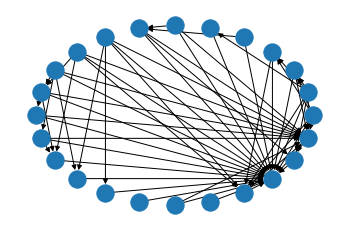

In [106]:
fig,ax = plt.subplots()
nx.draw_circular(sm,ax=ax)

In [107]:
correl_df = adjacency_correlations(struct_data,bn,'spearman')
# display_colored_df(correl_df)

In [108]:
correl_df

,1,3,4,ApplicationType,RequestedAmount,label,LoanGoal,2,6,5,8,7,9,16,17,10,12,15,11,14,13,18,19,20
1,NaN,1.000000,0.394846,0.636383,0.060184,0.167310,-0.203544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.060184,NaN,-0.203544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.005412,0.107883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicationType,NaN,NaN,NaN,NaN,-0.048210,NaN,-0.071848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RequestedAmount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,NaN,NaN,NaN,NaN,-0.003427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoanGoal,NaN,NaN,NaN,NaN,-0.070064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.980234,0.450100,0.471194,0.081182,0.146103,-0.214315,NaN,0.565967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,0.065897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,0.062226,NaN,NaN,NaN,NaN,NaN,-0.204458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
struct_data.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,ApplicationType_x,RequestedAmount_x,label_x,LoanGoal_x,NumberOfOffers,RequestedAmount_y,Selected,FirstWithdrawalAmount,MonthlyCost,NumberOfTerms,OfferedAmount,CreditScore,timesincelastevent,timesincecasestart,timesincemidnight,event_nr,month,weekday,hour,open_cases,durationDays
0,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.377996,0.130360,0.140674,0.140674,0.125044,0.214847,0.507688,0.466654,0.120619,0.527011,0.549518,0.477541,0.029765,0.040747,1,7,1,7,1,5000.0,0,5000.0,241.28,22.0,5000.0,899.0,0.001067,46923.253667,360,22,9,0,6,2271,30
1,0.647534,0.647534,0.647534,0.605800,0.529558,0.612453,0.176965,0.181836,0.181836,0.168306,0.295037,0.460255,0.507688,0.168752,0.548786,0.527011,0.141375,0.098399,0.022602,0.021743,1,147,0,4,1,12500.0,1,8304.0,250.00,57.0,12500.0,929.0,0.000067,11567.573967,662,25,6,4,11,1659,4
2,0.244644,0.352466,0.244644,0.278929,0.251265,0.251265,0.213892,0.549645,0.221787,0.246840,0.221787,0.460255,0.507688,0.466654,0.038264,0.042339,0.549518,0.051189,0.055837,0.074523,1,575,1,0,1,45000.0,0,8304.0,500.00,111.0,45000.0,899.0,0.000217,44044.188133,360,18,5,3,6,1533,30
